# Étude de la classification sur le dataset du diabète
## Objectif : 
Comparer plusieurs modèles de classification et tester différentes méthodes d'imputation des données manquantes

## 1. Importation des bibliothèques et chargement des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer

from imblearn.over_sampling import SMOTE

In [2]:
data = pd.read_csv("diabetes.csv")

## 2. Exploration et nettoyage des données

In [3]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [19]:
features_names = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]
cible_name = "Outcome"

X = data[features_names]
y = data[cible_name]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Nous observons des valeurs manquantes pour les variables : Glucose, BloodPressure, SkinThickness, Insulin et BMI

In [6]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Remplacer les 0 par Nan dans les colonnes concernées.

In [7]:
col_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in col_to_replace:
    data[col] = data[col].replace(0, np.nan)
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


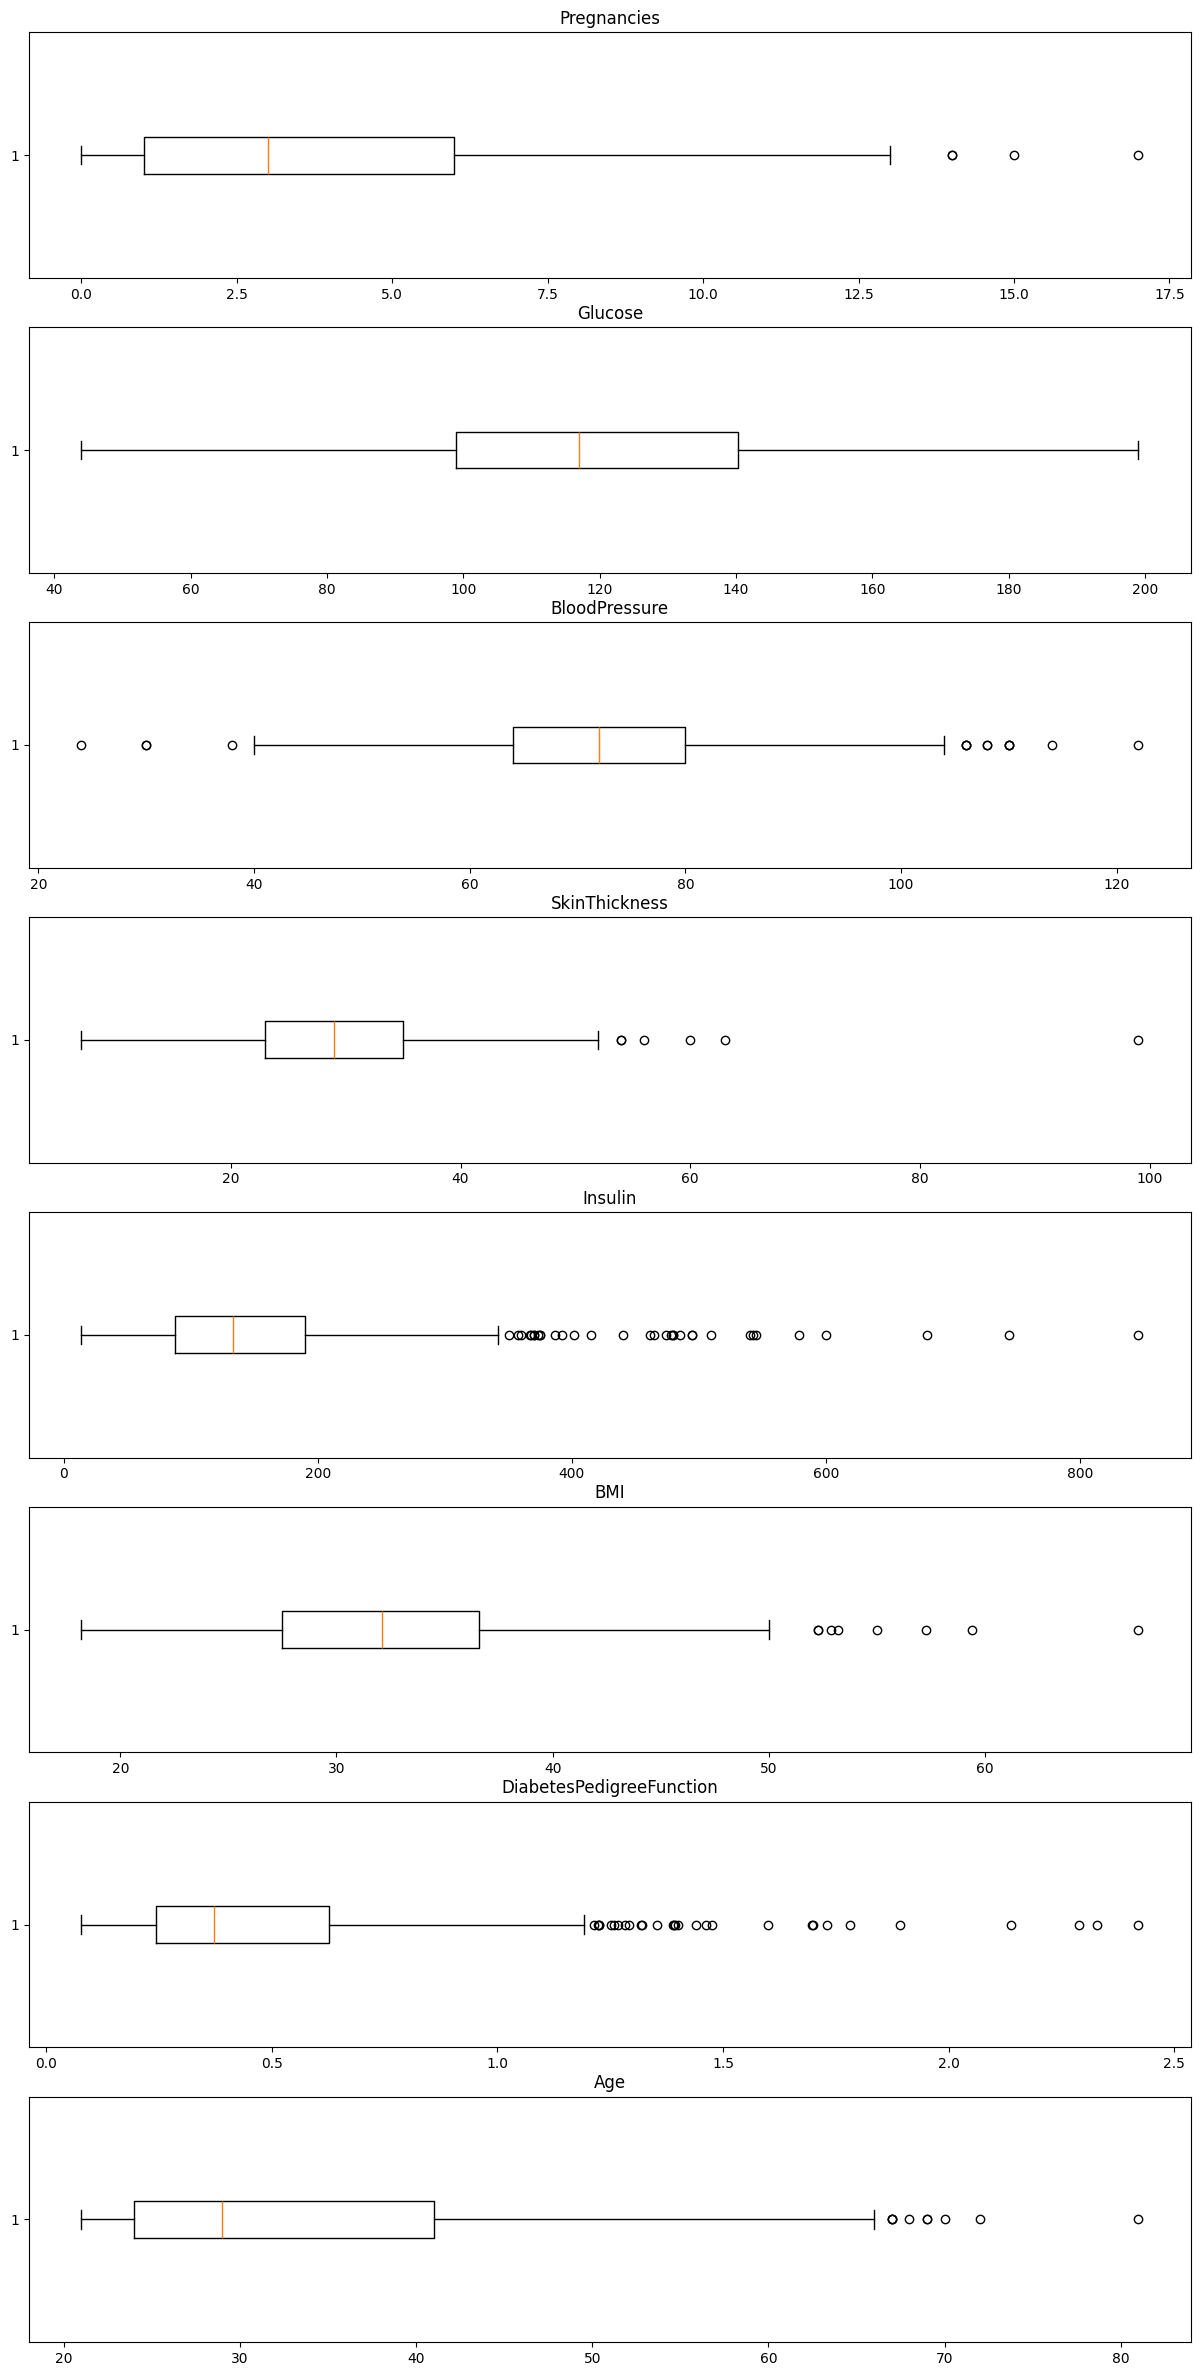

In [12]:
plt.figure(figsize=(15,30))
for i, name in enumerate(features_names):
    plt.subplot(len(features_names), 1, i+1)
    plt.title(name)
    plt.boxplot(data[name], vert=False)

In [21]:
# Créer l'imputer KNN avec 5 voisins
imputer = KNNImputer(n_neighbors=5)
scaler = StandardScaler()

# Transformer et normaliser pour que KNN fonctionne bien.
X_scaled = scaler.fit_transform(X)

# Appliquer aux données, cela renvoie un tableau numpy
X_imputed = imputer.fit_transform(X_scaled) 

X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns)

data_final = pd.concat([X_imputed_df, y.reset_index(drop=True)], axis=1)

print(data_final.head())

   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.639947  0.862287      -0.032746       0.558557  0.920984  0.165097   
1    -0.844885 -1.202229      -0.517645      -0.014657 -0.761629 -0.846404   
2     1.233880  2.009241      -0.679278       0.138200  0.359551 -1.323254   
3    -0.844885 -1.071148      -0.517645      -0.587871 -0.518847 -0.629654   
4    -1.141852  0.501816      -2.618874       0.558557  0.104968  1.537847   

   DiabetesPedigreeFunction       Age  Outcome  
0                  0.468492  1.425995        1  
1                 -0.365061 -0.190672        0  
2                  0.604397 -0.105584        1  
3                 -0.920763 -1.041549        0  
4                  5.484909 -0.020496        1  


In [22]:
data_final.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639947,0.862287,-0.032746,0.558557,0.920984,0.165097,0.468492,1.425995,1
1,-0.844885,-1.202229,-0.517645,-0.014657,-0.761629,-0.846404,-0.365061,-0.190672,0
2,1.233880,2.009241,-0.679278,0.138200,0.359551,-1.323254,0.604397,-0.105584,1
3,-0.844885,-1.071148,-0.517645,-0.587871,-0.518847,-0.629654,-0.920763,-1.041549,0
4,-1.141852,0.501816,-2.618874,0.558557,0.104968,1.537847,5.484909,-0.020496,1


Vérification de l'équilibre des données

In [12]:
data.loc[data["Outcome"] == 1, "Outcome"].count()

268

In [13]:
data.loc[data["Outcome"] == 0, "Outcome"].count()

500

Il y a deux fois moins de données pour les cas de diabète par rapport aux cas négatifs ce qui peux biaser le résultat. La solution est d'enrichir la classe minoritaire ou d'appauvrir la majoritaire. Ici au choisi le 1er cas pour ne pas perdre de données.

### Séparation en jeu d'entrainement et de test et création de nouveaux exemples synthétiques pour la classe minoritaire (ici outcome=1 donc cas diabétiques)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(data_final[features_names], data_final[cible_name], test_size=0.2, random_state=24 )
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Utilisant la validation croisée puis entrainement du modèle
## 1 Modèle de régression logistique

In [29]:
model = LogisticRegression()
scores = cross_val_score(model, X_resampled, y_resampled, cv=5)
print(f'Mean accurancy: {scores.mean()}')
print(f'Accurancy: {scores}')

model.fit(X_resampled, y_resampled)

Mean accurancy: 0.7636956521739131
Accurancy: [0.74534161 0.82608696 0.70807453 0.76397516 0.775     ]


LogisticRegression()

In [30]:
y_pred = model.predict(X_test)

### Affichage des différents scores

In [31]:
def print_metric(y_test, y_pred):
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Precision score: {precision}")
    print(f"Recall score: {recall}")
    print(f"f1 score: {f1}")
    print(f"Confusion matrix: \n{cm}")

    print("Rapport de classification :\n", classification_report(y_test, y_pred))

print_metric(y_test, y_pred)

Precision score: 0.6296296296296297
Recall score: 0.6071428571428571
f1 score: 0.6181818181818182
Confusion matrix: 
[[78 20]
 [22 34]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.78      0.80      0.79        98
           1       0.63      0.61      0.62        56

    accuracy                           0.73       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.73      0.73      0.73       154



## 2 Algorithme des K-Nearest Neighbors (KNN)

In [33]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [2, 3, 4, 5, 7, 9]}
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_resampled, y_resampled)
print(f"Best k: {grid_search.best_params_}")


Best k: {'n_neighbors': 3}


In [34]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_resampled, y_resampled)
y_knn_pred = knn.predict(X_test)

### Affichage des différents scores

In [35]:
print_metric(y_test, y_knn_pred)

Precision score: 0.6037735849056604
Recall score: 0.5714285714285714
f1 score: 0.5871559633027523
Confusion matrix: 
[[77 21]
 [24 32]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.76      0.79      0.77        98
           1       0.60      0.57      0.59        56

    accuracy                           0.71       154
   macro avg       0.68      0.68      0.68       154
weighted avg       0.70      0.71      0.71       154



L'algorithme des k plus proches voisins a plus de précision mais un moins bon rappel, il y a moins de faux positifs mais plus de faux négatifs. 

In [36]:
param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],  
    'max_depth': [2, 40, 50, 70, 100, 150], 
    'max_features': [None, 'sqrt', 'log2']  
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=24), param_grid, cv=5, scoring='recall')
grid_search.fit(X_resampled, y_resampled)
print(f'Best parameters: {grid_search.best_params_}')



Best parameters: {'max_depth': 40, 'max_features': 'sqrt', 'n_estimators': 300}


In [37]:
rf = RandomForestClassifier(n_estimators=300, random_state=24, max_features='sqrt', max_depth=40)
rf.fit(X_resampled, y_resampled)
y_rf_pred = rf.predict(X_test)

In [39]:
print_metric(y_test, y_rf_pred)

Precision score: 0.6666666666666666
Recall score: 0.6071428571428571
f1 score: 0.6355140186915887
Confusion matrix: 
[[81 17]
 [22 34]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.79      0.83      0.81        98
           1       0.67      0.61      0.64        56

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.72       154
weighted avg       0.74      0.75      0.74       154



Avec imputation des valeurs nulles par KNN les scores du modèle RandomForestClassifier est meilleur que les deux autres il est d'ailleur plus précis que le modèle de régression logistique sans imputation de valeur qui avait eu jusque là le meilleur score (0.74).